In [1]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import glob
import datetime
import math
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
import folium
import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [310]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)

In [5]:
df = pd.read_pickle("./Data/dataframefull.pickle")
df_art = pd.read_pickle("./Data/articles.pickle")
df_user_full = pd.read_pickle("./Data/clv2u.pickle")

In [4]:
df.head()

,visit_id,user_id,visit_number,date,day_of_week,article_name,article_id,price,quantity,total_price,shop_cart_value,shop_cart_item_count,shop_cart_unique_articles,country,region,city,city_id,women_article,men_article,kids_article,homeandliving_article,campaign_involved,category,category_slim,brand,product_line,product_group,genre_column_placeholder,device_category,device_browser,device_os,stock_value,year_month,min_purchase_date,user_type
0,551960553811,553811,1,2018-09-10,0,Geschenkgutschein 10 EUR,200000000010,10.0,1,10.0,30.0,2,2,Germany,Lower Saxony,Brunswick,1004478,0,1,0,0,False,Herren,men,(not set),Herren,Herren,Geschenkgutschein 10 EUR/Herren/Herren/Herren,desktop,Firefox,Windows,5.77,201809,201809,first
1,551960553811,553811,1,2018-09-10,0,Geschenkgutschein 20 EUR,200000000020,20.0,1,20.0,30.0,2,2,Germany,Lower Saxony,Brunswick,1004478,0,1,0,0,False,Herren,men,(not set),Herren,Herren,Geschenkgutschein 20 EUR/Herren/Herren/Herren,desktop,Firefox,Windows,5.77,201809,201809,first
2,242735254033,254033,1,2018-01-04,3,Geschenkgutschein 10 EUR,200000000010,10.0,1,10.0,80.0,3,3,Germany,Lower Saxony,Wunstorf,9048892,1,1,0,0,True,Damen/Geschenkgutscheine,women/men,(not set),Herren,Herren,Geschenkgutschein 10 EUR/Damen/Geschenkgutsche...,desktop,Firefox,Windows,11.40,201801,201801,first
3,242735254033,254033,1,2018-01-04,3,Geschenkgutschein 20 EUR,200000000020,20.0,1,20.0,80.0,3,3,Germany,Lower Saxony,Wunstorf,9048892,1,1,0,0,True,Damen/Geschenkgutscheine,women/men,(not set),Herren,Herren,Geschenkgutschein 20 EUR/Damen/Geschenkgutsche...,desktop,Firefox,Windows,11.40,201801,201801,first
4,242735254033,254033,1,2018-01-04,3,Geschenkgutschein 50 EUR,200000000050,50.0,1,50.0,80.0,3,3,Germany,Lower Saxony,Wunstorf,9048892,1,1,0,0,True,Damen/Geschenkgutscheine,women/men,(not set),Herren,Herren,Geschenkgutschein 50 EUR/Damen/Geschenkgutsche...,desktop,Firefox,Windows,11.40,201801,201801,first


In [48]:
df_art.head()

,visit_id,date,article_id,article_name,price,women_article,men_article,kids_article,homeandliving_article,category_slim,brand
226,570727363200,2017-11-19,200000000010,Geschenkgutschein 10 EUR,10.0,0,1,0,0,men,(not set)
29,135611602309,2017-11-22,200000000010,Geschenkgutschein 10 EUR,10.0,0,1,0,0,men,(not set)
174,199278169302,2017-11-25,200000000010,Geschenkgutschein 10 EUR,10.0,0,1,0,0,men,(not set)
83,253024190019,2017-12-04,200000000010,Geschenkgutschein 10 EUR,10.0,0,1,0,0,men,(not set)
115,482743120185,2017-12-11,200000000010,Geschenkgutschein 10 EUR,10.0,1,1,0,0,women/men,(not set)


## extra dataframes for plotting

In [29]:
#TD

Dataframe for the total revenue at a given date and the total quantity at a given date

In [305]:
summation = df.groupby(["date"]).sum()
df_sum = pd.DataFrame(summation,columns=["total_price"])
df_sum.reset_index(level=0,inplace=True)
df_quant = pd.DataFrame(summation,columns=["quantity"])
df_quant.reset_index(level=0,inplace=True)

Scale total revenue and quantity to put them both into a plot and make them compareable

In [306]:
std_scaler = preprocessing.StandardScaler()
sum_scale = df_sum.copy()
quant_scale = df_quant.copy()
sum_scale["total_price"] = std_scaler.fit_transform(df_sum[["total_price"]])
quant_scale["quantity"] = std_scaler.fit_transform(df_quant[["quantity"]])

In [307]:
#give quant_scale a feature with zeroes to easier plot a null line later
quant_scale["null"] = 0

In [33]:
#TD
#dataframe for plotting the shopping cart value over time
df_plot_time_to_cartvalue = df.drop_duplicates(subset ="visit_id")

In [308]:
#df_clv = pd.read_pickle("./Data/clv2u.pickle")
#ger_cities_latlng = pd.read_csv("./Data/cities_latlng.csv")

# Plots

### revenue and quantity per date (unscaled)

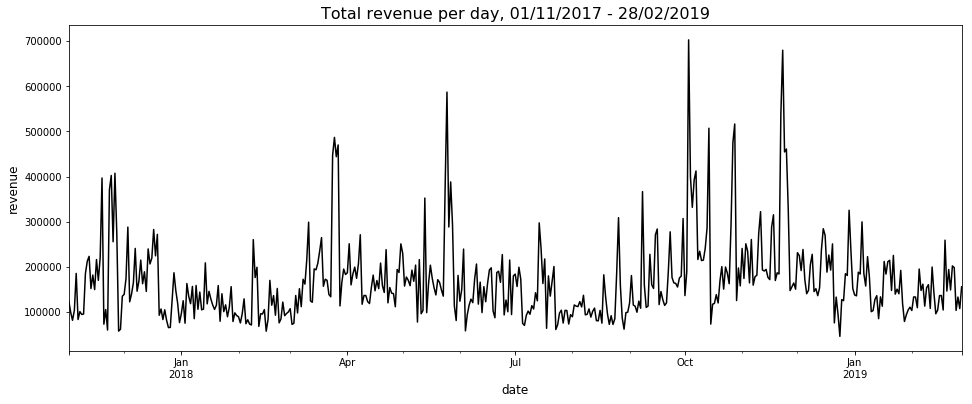

In [34]:
plt.figure(figsize=(16,6))
df_sum.set_index('date').total_price.plot(color='black')
plt.xlim('2017-11-01', '2019-02-28')
plt.xlabel('date', fontsize=12)
plt.ylabel('revenue', fontsize=12)
plt.title('Total revenue per day, 01/11/2017 - 28/02/2019', fontsize=16)
plt.show()

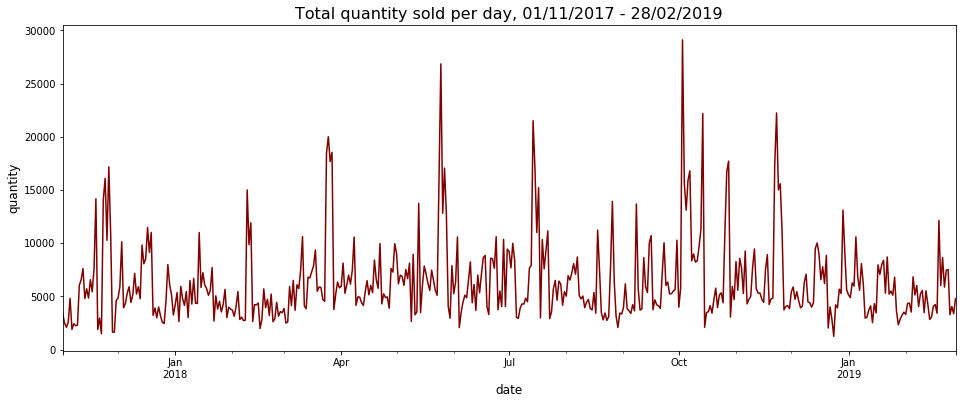

In [35]:
plt.figure(figsize=(16,6))
df_quant.set_index('date').quantity.plot(color='maroon')
plt.xlim('2017-11-01', '2019-02-28')
plt.xlabel('date', fontsize=12)
plt.ylabel('quantity', fontsize=12)
plt.title('Total quantity sold per day, 01/11/2017 - 28/02/2019', fontsize=16)
plt.show()

### total revenue and quantity per date (scaled)

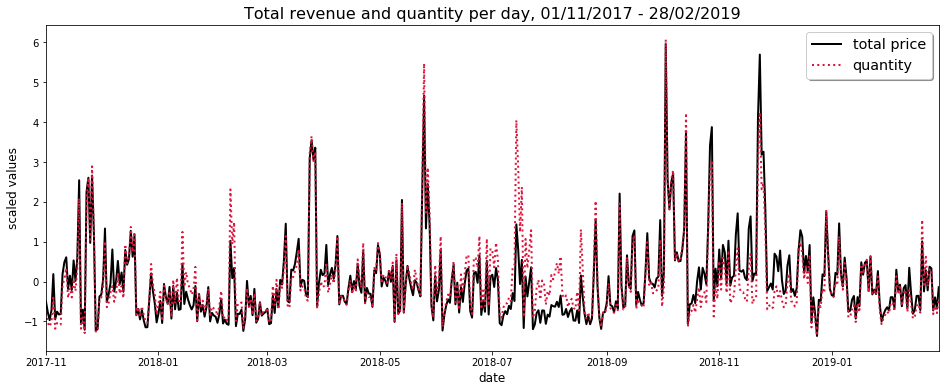

In [36]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(sum_scale["date"], sum_scale["total_price"], 'k-', label='total price', linewidth=2)
ax.plot(quant_scale["date"], quant_scale["quantity"], color="crimson" ,linestyle=':', label='quantity', linewidth=2)

plt.xlim('2017-11-01', '2019-02-28')

plt.xlabel('date', fontsize=12)
plt.ylabel('scaled values', fontsize=12)
plt.title('Total revenue and quantity per day, 01/11/2017 - 28/02/2019', fontsize=16)

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

# background color on the legend
legend.get_frame().set_facecolor('w')

plt.show()

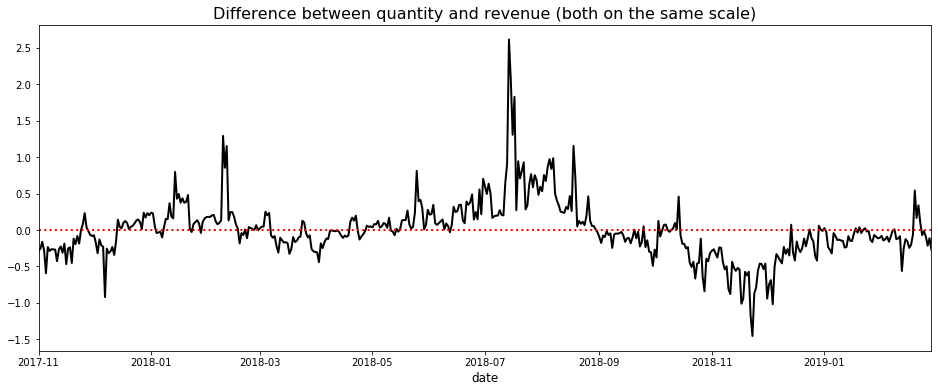

In [314]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(sum_scale["date"], (quant_scale.set_index('date').quantity - sum_scale.set_index('date').total_price), color='black', linestyle='-', linewidth=2, label="difference between quantity and price")
ax.plot(quant_scale["date"], quant_scale.set_index('date').null, color='red', linestyle=':', linewidth=2)

plt.xlim('2017-11-01', '2019-02-28')

plt.xlabel('date', fontsize=12)
plt.title('Difference between quantity and revenue (both on the same scale)', fontsize=16)
plt.show()
fig.savefig( './Data/Diff.png', bbox_inches='tight') 

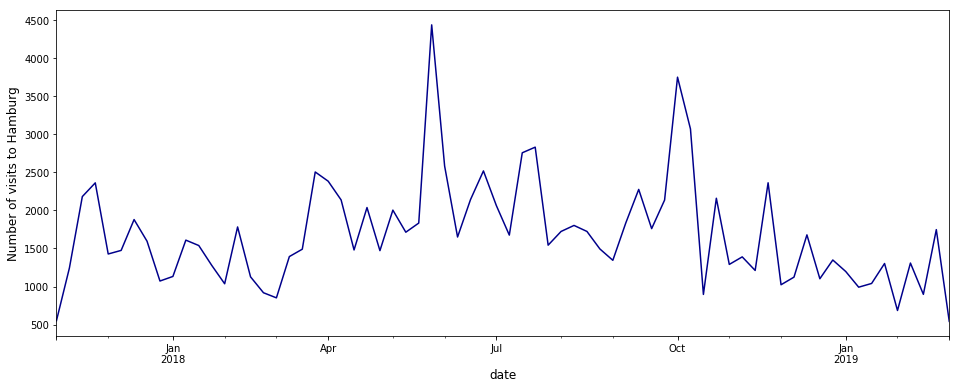

In [38]:
#testplot for hamburg
plt.figure(figsize=(16,6))
df[df['city'] == 'Hamburg'].set_index('date').visit_number.resample('W').count().plot(color='darkblue')
plt.xlim('2017-11-01', '2019-02-28')
plt.xlabel('date', fontsize=12)
plt.ylabel('Number of visits to Hamburg', fontsize=12)
#plt.title('Number of successful funded projects (per week), 04/2009 - 03/2019', fontsize=16)
plt.show()

//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


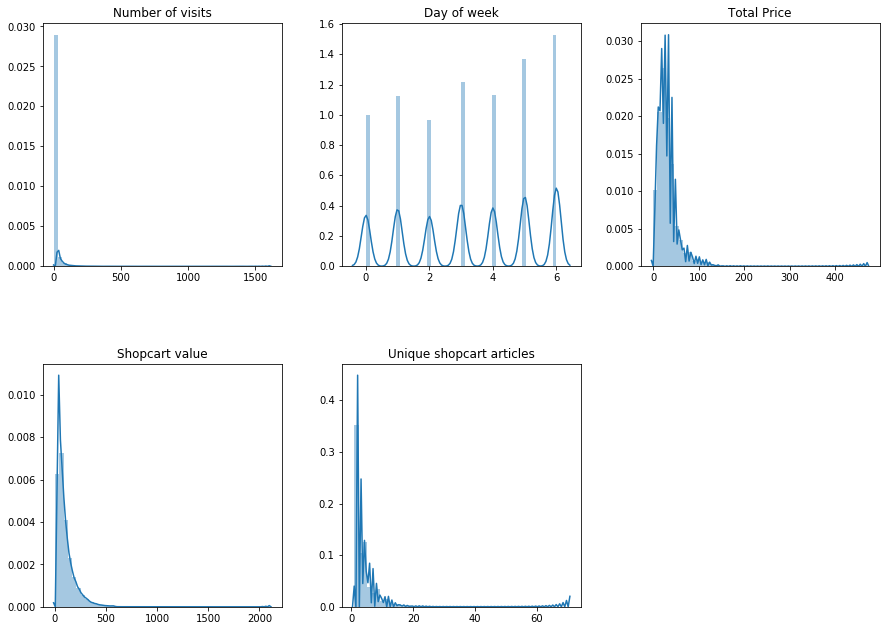

In [40]:
fig, ax = plt.subplots(2,3,figsize=(15,17))
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# visits
plt.subplot(331)
sns.distplot(df.visit_number)
plt.title('Number of visits')
plt.xlabel('');

# day of week
plt.subplot(332)
sns.distplot(df.drop_duplicates(subset ="visit_id").day_of_week)
plt.title('Day of week')
plt.xlabel('');

# Total Price
plt.subplot(333)
sns.distplot(df.drop_duplicates(subset ="visit_id").total_price)
plt.title('Total Price')
plt.xlabel('');

# Shopping cart value
plt.subplot(334)
sns.distplot(df.drop_duplicates(subset ="visit_id").shop_cart_value)
plt.title('Shopcart value')
plt.xlabel('');

# Unique articles is cart
plt.subplot(335)
sns.distplot(df.drop_duplicates(subset ="visit_id").shop_cart_unique_articles)
plt.title('Unique shopcart articles')
plt.xlabel('');

plt.subplot(336)
plt.axis('off');



# 2. Article lifecycle plot function

In [35]:
#drop samples where vouchers were used to reduce price to 0 as they would place heavy outliers not saying anything
df_art_nnull = df_art[df_art["price"]!=0]

In [36]:
df_art_nnull.reset_index(drop=True, inplace=True)

In [59]:
#nicer plot with seaborn below , hence commented out
'''def lc_plot(article_id):
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(df_art_nnull[df_art_nnull["article_id"]==article_id]["date"]\
            , df_art_nnull[df_art_nnull["article_id"]==article_id]["price"], 'k-', label='price', linewidth=2)
    plt.xlim(df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].min()\
             , df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].max())

    plt.xlabel('date', fontsize=12)
    plt.ylabel('price', fontsize=12)
    plt.title('Lifecylce of article {} (ID : {}), {} - {}'.format(df_art_nnull[df_art_nnull["article_id"]==article_id]["article_name"].min()\
                                                        , article_id\
                                                        , df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].min()\
                                                        , df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].max())\
              , fontsize=16)

    #legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

    # background color on the legend
    #legend.get_frame().set_facecolor('w')

    plt.show()'''

#### Function to plot a single article:

In [13]:
def lc_plot(article_id):

    g = sns.relplot(x="date", y="price", kind="line", marker="o", data=df_art_nnull[df_art_nnull["article_id"]==article_id], height=5, aspect=2)
    g.fig.autofmt_xdate()
    maxdate = df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].max()
    mindate = df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].min()
    plt.title('Lifecylce of article {} (ID : {}), {} - {}'.format(df_art_nnull[df_art_nnull["article_id"]==article_id]["article_name"].max()\
                                                        , article_id\
                                                        , mindate.strftime("%m/%d/%Y")\
                                                        , maxdate.strftime("%m/%d/%Y"))\
              , fontsize=14)
    plt.show()

In [7]:
df_art_nnull.sample(n=5)

,visit_id,date,article_id,article_name,price,women_article,men_article,kids_article,homeandliving_article,category_slim,brand
142351,61197643328,2018-09-16,4060868338529,T-Shirt mit Print,9.40,0,0,0,0,(not set),TT_Casual
1064713,695514549412,2017-12-07,4059066405706,Herren-T-Shirt mit Schriftzug,10.92,0,1,0,0,men,TT_Casual
911374,798615147893,2018-05-03,4060586754601,Alexa Bermuda Shorts,26.89,1,0,0,0,women,(not set)
332445,624089191102,2018-01-04,4043825526856,Ledergürtel mit Metallschlaufen,12.60,1,0,0,0,women,TT_Casual
2497766,164840163282,2018-08-09,4060868073062,Chino Slim Shorts mit Gürtel,32.14,0,1,0,0,men,TT_Denim


//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda3/envs/nf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


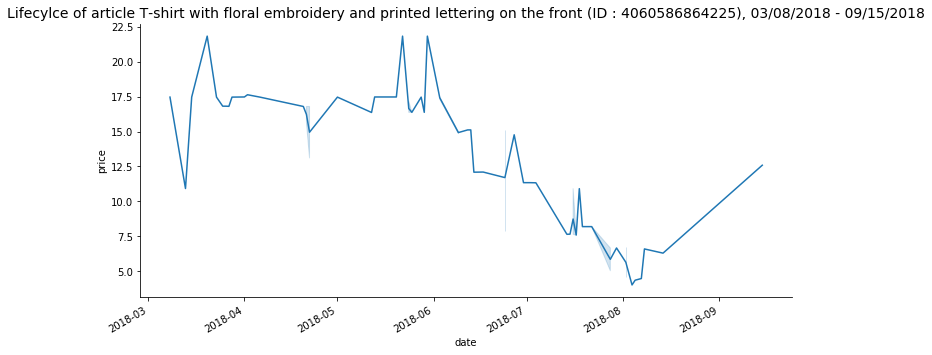

In [20]:
lc_plot(4060586864225)

#### Function to plot a sample of given, even, size

In [6]:
def samplot(size):
    '''Takes the size of the sample to be plotted. For ease of use please only use even numbers'''
    if size % 2 != 0:
        print("Error: Please use an even sample size.")
    else:
        fig, axes = plt.subplots(math.ceil(size/2),2, figsize=(17,17), sharex=True)
        fig.autofmt_xdate()
        pltdata = df_art_nnull.sample(n=size)
        artlist = pltdata["article_id"].tolist()
        for i, ax in enumerate(axes.flat):
            sns.relplot(x="date", y="price", kind="line", marker="o", data=df_art_nnull[df_art_nnull["article_id"]==artlist[i]], ax=ax)
            ax.set_title('{}, {}'.format(pltdata[pltdata["article_id"]==artlist[i]]["article_name"].min(), pltdata[pltdata["article_id"]==artlist[i]]["article_id"].min()))

        for i in range(1, len(artlist)+1):
            plt.close(i+1)

//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


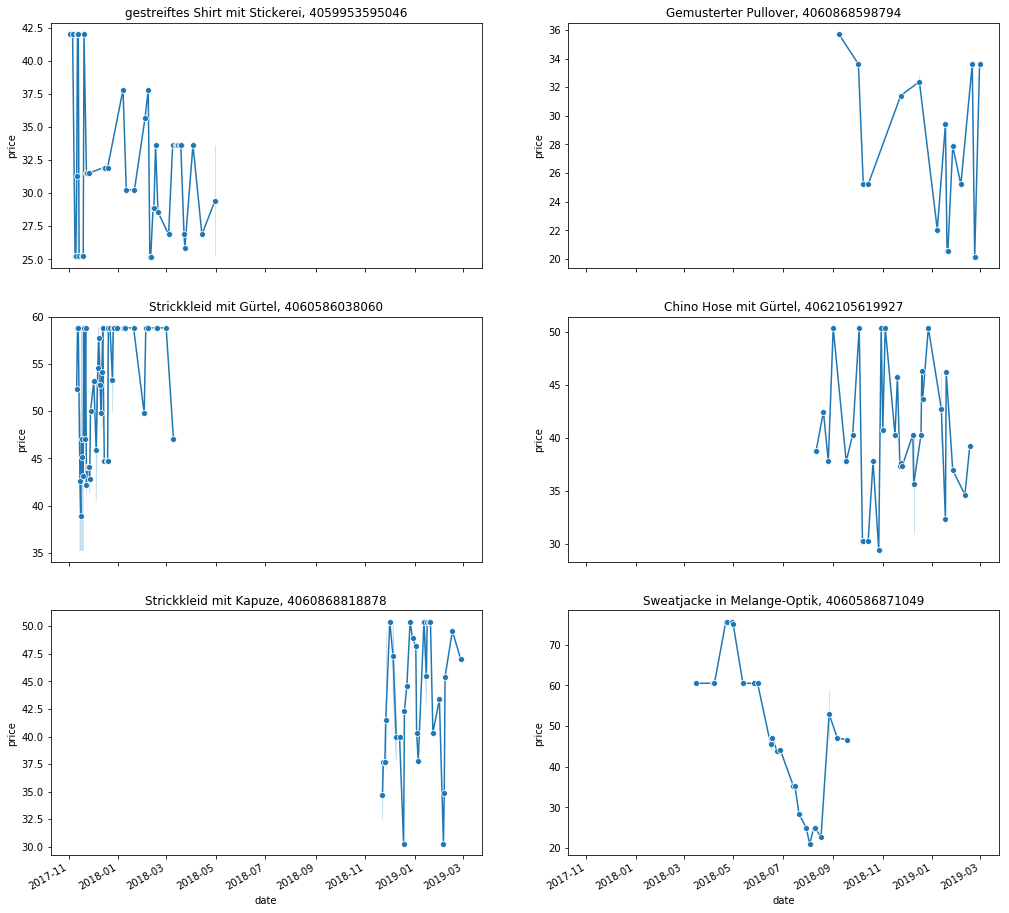

In [10]:
samplot(6);

In [41]:
def samscatter(size):
    '''Takes the size of the sample to be plotted. For ease of use please only use even numbers'''
    if size % 2 != 0:
        print("Error: Please use an even sample size.")
    else:
        fig, axes = plt.subplots(math.ceil(size/2),2, figsize=(17,17), sharex=True)
        fig.autofmt_xdate()
        pltdata = df_art_nnull.sample(n=size)
        artlist = pltdata["article_id"].tolist()
        for i, ax in enumerate(axes.flat):
            ax.plot(df_art_nnull[df_art_nnull["article_id"]==artlist[i]]['date'], df_art_nnull[df_art_nnull["article_id"]==artlist[i]]['price'], linestyle='None', marker='o')
            ax.set_title('{}, {}'.format(pltdata[pltdata["article_id"]==artlist[i]]["article_name"].min(), pltdata[pltdata["article_id"]==artlist[i]]["article_id"].min()))

        for i in range(1, len(artlist)+1):
            plt.close(i+1)

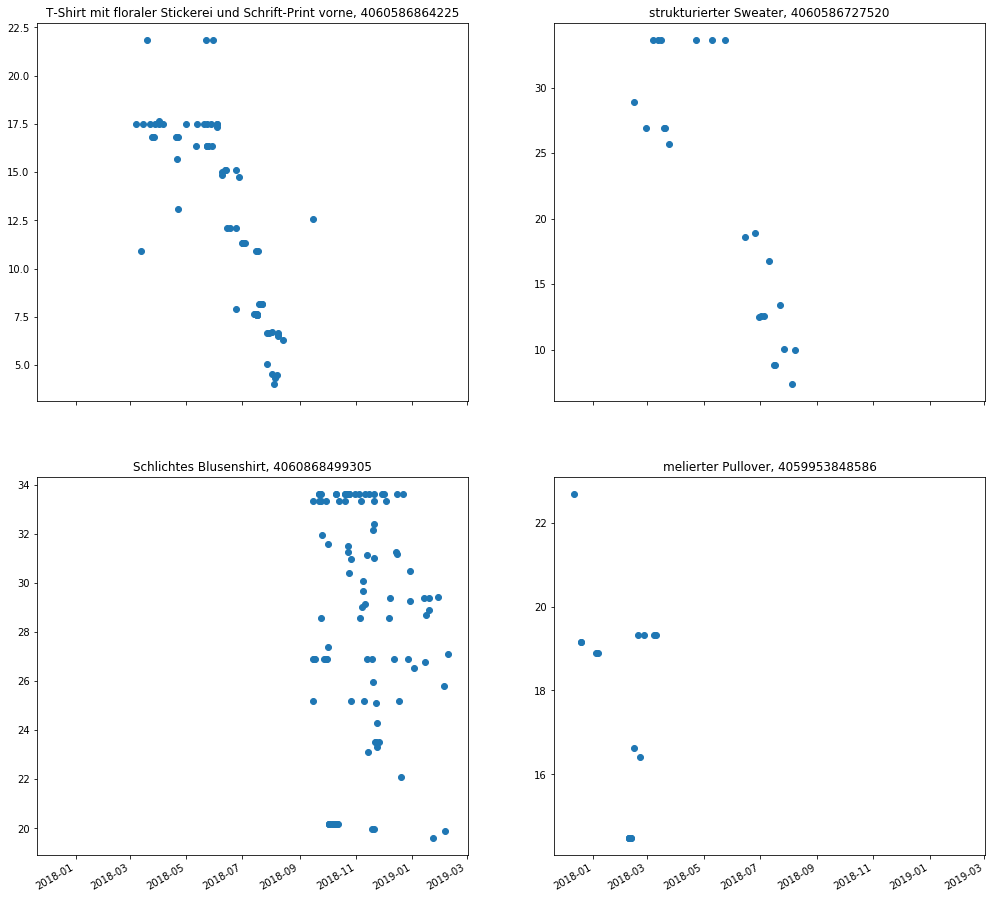

In [42]:
samscatter(6)

In [ ]:
#TD check maybe like all skinny jeans ( regex)

In [ ]:
sale = df.drop_duplicates(subset ="visit_id").pivot_table(index=['user_id'],columns=['year_month'],values='shop_cart_value',aggfunc='sum',fill_value=0).reset_index()
sale['clv']=sale.iloc[:,2:].sum(axis=1)
sale.head()

### Bestseller

In [8]:
df["article_id"].value_counts()#.sort_values()

4059066698719    1728
4059066698511    1284
4002702235090    1215
4059066698726    1176
4059066698733    1054
                 ... 
4060586203765       1
4059995052286       1
4060868296935       1
4060463174980       1
4060868915508       1
Name: article_id, Length: 101441, dtype: int64

In [36]:
df[(df["men_article"]>0) & (df["women_article"]==0)].article_id.value_counts()

4002702235090    1215
4002702235083     783
4052691223851     781
4054985602212     765
4052691223844     751
                 ... 
4061945019836       1
4060868212256       1
4060868864103       1
4060868703051       1
4061945645578       1
Name: article_id, Length: 42274, dtype: int64

In [10]:
df[df["article_id"]==4059066698719]

,visit_id,user_id,visit_number,date,day_of_week,article_name,article_id,price,quantity,total_price,shop_cart_value,shop_cart_item_count,shop_cart_unique_articles,country,region,city,city_id,women_article,men_article,kids_article,homeandliving_article,campaign_involved,category,category_slim,brand,product_line,product_group,genre_column_placeholder,device_category,device_browser,device_os,stock_value,year_month,min_purchase_date,user_type
346,178761566560,566560,85,2018-08-11,5,Lässige Damen-Stoffhose,4059066698719,25.88,1,25.88,273.33,10,10,Germany,North Rhine-Westphalia,Essen,1004625,1,0,0,0,True,Damen/Neu im Sale,women,TT_Denim,Damen,Hosen,Lässige Damen-Stoffhose/Damen/Neu im Sale/Dame...,mobile,Samsung Internet,Android,7.0050,201808,201801,established
15328,151068386910,386910,62,2018-10-08,0,Lässige Damen-Stoffhose,4059066698719,26.89,1,26.89,51.08,2,2,Germany,Thuringia,Suhl,1004999,1,0,0,0,True,Damen,women,TT_Denim,Damen,Hosen,Lässige Damen-Stoffhose/Damen/Damen/Hosen,desktop,Safari,Macintosh,3.5940,201810,201711,established
46460,38994159464,59464,18,2018-07-13,4,Lässige Damen-Stoffhose,4059066698719,17.64,1,17.64,66.45,4,4,Germany,North Rhine-Westphalia,Zulpich,9048900,1,0,0,0,True,Damen/Neu im Sale,women,TT_Denim,Damen,Hosen,Lässige Damen-Stoffhose/Damen/Neu im Sale/Dame...,mobile,Safari (in-app),iOS,6.1650,201807,201711,established
50731,605784457216,457216,25,2018-08-10,4,Lässige Damen-Stoffhose,4059066698719,25.87,1,25.87,67.88,2,2,Germany,Lower Saxony,Harsefeld,9048401,1,0,0,0,True,Damen/Neu im Sale,women,TT_Denim,Damen,Hosen,Lässige Damen-Stoffhose/Damen/Neu im Sale/Dame...,desktop,Firefox,Windows,7.1200,201808,201808,first
50740,338215391555,391555,12,2018-12-29,5,Lässige Damen-Stoffhose,4059066698719,27.19,1,27.19,72.00,5,5,Germany,Bavaria,Vilsbiburg,1004313,1,0,0,0,True,Damen/Damenmode/Hosen,women,TT_Denim,Damen,Hosen,Lässige Damen-Stoffhose/Damen/Damenmode/Hosen/...,mobile,Safari,iOS,2.3220,201812,201810,established
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120634,723406421433,421433,126,2018-10-28,6,Lässige Damen-Stoffhose,4059066698719,25.96,1,25.96,71.41,2,2,Germany,North Rhine-Westphalia,Bonn,1004597,1,0,0,0,True,Jogginghosen/Damen,women,TT_Denim,Damen,Hosen,Lässige Damen-Stoffhose/Jogginghosen/Damen/Dam...,desktop,Chrome,Windows,3.1010,201810,201712,established
1120661,685124341560,341560,1,2018-10-28,6,Lässige Damen-Stoffhose,4059066698719,26.88,1,26.88,84.01,3,3,Germany,Hamburg,Hamburg,1004437,1,0,0,0,True,Jogginghosen/Damen,women,TT_Denim,Damen,Hosen,Lässige Damen-Stoffhose/Jogginghosen/Damen/Dam...,tablet,Android Webview,Android,3.1010,201810,201810,first
1120664,509135239740,239740,2,2018-07-14,5,Lässige Damen-Stoffhose,4059066698719,17.65,1,17.65,245.16,21,19,Germany,Bavaria,Nuremberg,1004246,1,0,0,0,True,Damen/Neu im Sale,women,TT_Denim,Damen,Hosen,Lässige Damen-Stoffhose/Damen/Neu im Sale/Dame...,tablet,Safari,iOS,6.1975,201807,201807,first
1120683,568874574208,574208,31,2018-07-14,5,Lässige Damen-Stoffhose,4059066698719,17.64,1,17.64,301.67,16,16,Germany,Bavaria,Forchheim,1004157,1,0,0,0,True,Damen/Neu im Sale,women,TT_Denim,Damen,Hosen,Lässige Damen-Stoffhose/Damen/Neu im Sale/Dame...,tablet,Safari,iOS,6.1975,201807,201807,first


//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


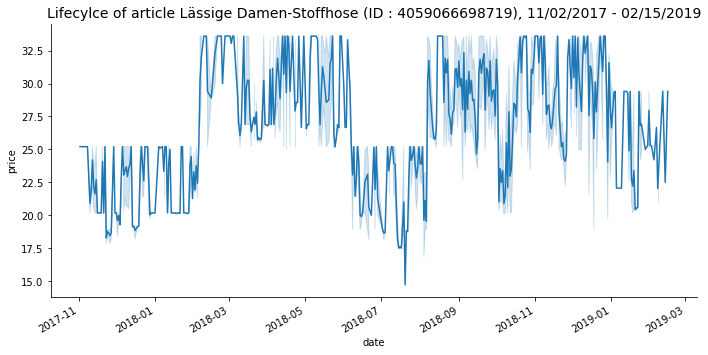

In [21]:
lc_plot(4059066698719)

//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


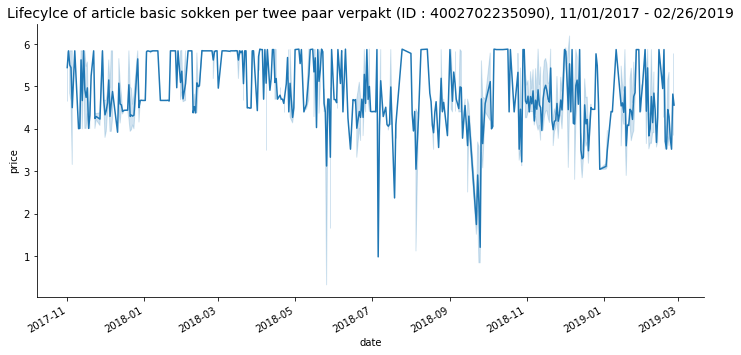

In [37]:
lc_plot(4002702235090)

### Cashcow Article

In [26]:
#cashcow all
df_art_nnull.groupby("article_id").sum().sort_values(by="price")

,visit_id,price,women_article,men_article,kids_article,homeandliving_article
article_id,,,,,,
4060868144564,263584311792,0.73,0,3,0,0
4060463175819,532452540354,0.84,1,0,0,0
4060463178209,741855228822,0.84,0,0,1,0
4060868144748,876683639856,0.87,0,2,0,0
4060463041800,431607456377,1.68,0,0,1,0
...,...,...,...,...,...,...
4059491843302,240646490884254,31640.39,675,0,0,0
4059066698511,443077734624328,31834.10,1284,1284,0,0
4059491843289,228074775766900,31838.75,677,0,0,0


In [29]:
#cashcow men
df_art_nnull[df_art_nnull["men_article"]>0].groupby("article_id").sum().sort_values(by="price")

,visit_id,price,women_article,men_article,kids_article,homeandliving_article
article_id,,,,,,
4060868144564,263584311792,0.73,0,3,0,0
4060868144748,876683639856,0.87,0,2,0,0
4060868144908,901622620758,1.68,0,4,0,0
4060868144595,2596668974107,1.85,0,8,0,0
4060868144939,2184112802106,3.78,0,9,0,0
...,...,...,...,...,...,...
4056762815792,229733268830817,22087.46,0,659,0,0
4062105536613,72982753340878,23973.85,212,212,0,0
4062105536484,80678221516275,24853.36,228,228,0,0


//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


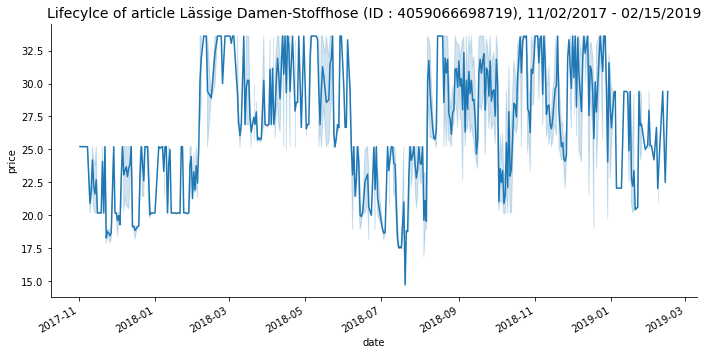

In [27]:
lc_plot(4059066698719)

//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


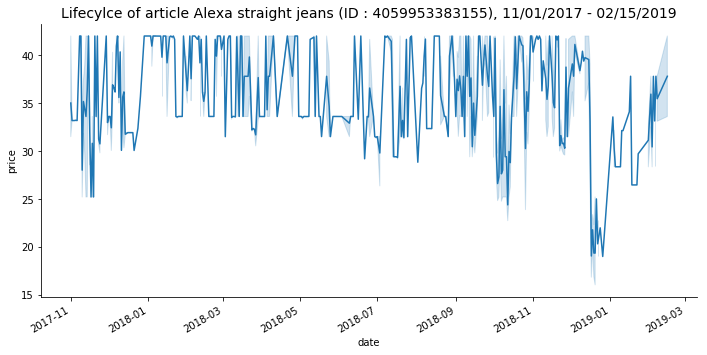

In [28]:
lc_plot(4059953383155)

//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


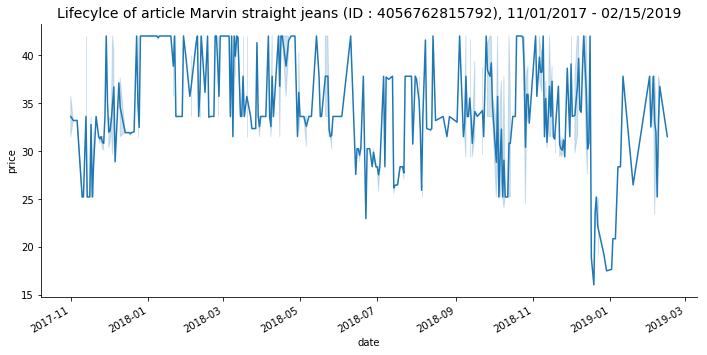

In [31]:
lc_plot(4056762815792)

In [38]:
#TD plot most sold articles etc grouped by user score

# Clustering plot

In [103]:
df_user_full.score.value_counts()

2    228317
1    176726
0    145617
3     49072
4     17381
5      4237
6      1267
Name: score, dtype: int64

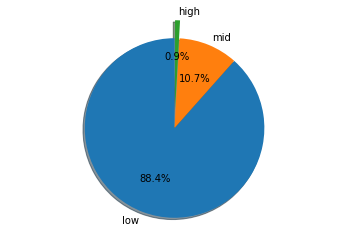

In [45]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'low', 'mid', 'high'
sizes = df_user_full.value_segment.value_counts()
explode = (0, 0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

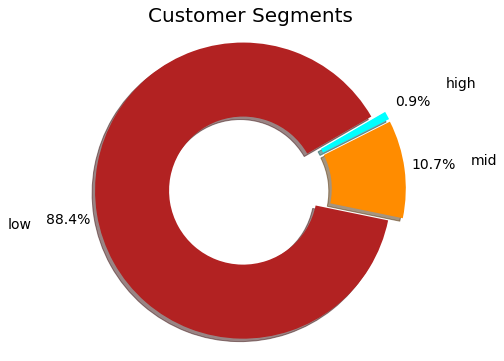

In [122]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'low', 'mid', 'high'
sizes = df_user_full.value_segment.value_counts()
explode = (0.05, 0.05, 0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
fig1.set_figheight(6)
fig1.set_figwidth(6)
ax1.set_title("Customer Segments", fontsize=20)
ax1.pie(sizes, explode=explode, labels=labels, wedgeprops=dict(width=0.5),
        autopct='%1.1f%%', labeldistance=1.45, pctdistance=1.2, shadow=True,
        startangle=30, textprops={'fontsize': 14}, colors=["firebrick", "darkorange", "aqua"])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
fig1.savefig( './Data/CustomerSegments.png', bbox_inches='tight') 

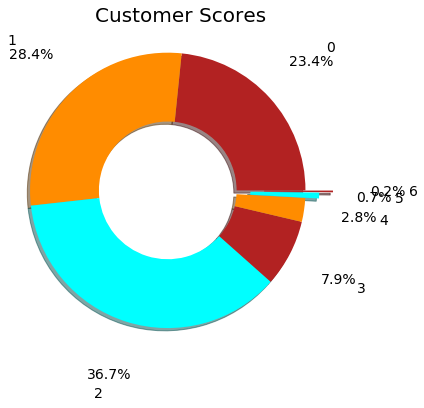

In [116]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '0', '1', '2', '3', '4', '5', '6'
sizes = df_user_full.score.value_counts().sort_index()
explode = (0, 0, 0, 0, 0, 0.1, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
fig1.set_figheight(6)
fig1.set_figwidth(6)
ax1.set_title("Customer Scores", fontsize=20)
ax1.pie(sizes, explode=explode, labels=labels, wedgeprops=dict(width=0.5),
        autopct='%1.1f%%', labeldistance=1.55, pctdistance=1.4, shadow=True,
        startangle=0, textprops={'fontsize': 14}, colors=["firebrick", "darkorange", "aqua"])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
fig1.savefig( './Data/CustomerScores.png', bbox_inches='tight') 

In [229]:
len(df_user_full[df_user_full["value_segment"]=="low"])

550660

In [230]:
df_user_full[df_user_full["value_segment"]=="low"].score.value_counts()

2    228317
1    176726
0    145617
Name: score, dtype: int64

In [148]:
scorelist = []

In [149]:
for i in df_user_full[df_user_full["value_segment"]=="low"].score.value_counts().sort_index().index.tolist():
    scorelist.append(df_user_full[df_user_full["value_segment"]=="low"].score.value_counts().sort_index()[i])

In [150]:
for i in df_user_full[df_user_full["value_segment"]=="mid"].score.value_counts().sort_index().index.tolist():
    scorelist.append(df_user_full[df_user_full["value_segment"]=="mid"].score.value_counts().sort_index()[i])

In [151]:
for i in df_user_full[df_user_full["value_segment"]=="high"].score.value_counts().sort_index().index.tolist():
    scorelist.append(df_user_full[df_user_full["value_segment"]=="high"].score.value_counts().sort_index()[i])

In [152]:
scorelist

[145617, 176726, 228317, 49072, 17381, 4237, 1267]

In [249]:
pctlist = []

In [250]:
for i in df_user_full[df_user_full["value_segment"]=="low"].score.value_counts().sort_index().index.tolist():
    pctlist.append(("{}%".format(round(df_user_full[df_user_full["value_segment"]=="low"].score.value_counts().sort_index()[i]/len(df_user_full[df_user_full["value_segment"]=="low"])*100,2))))

In [251]:
for i in df_user_full[df_user_full["value_segment"]=="mid"].score.value_counts().sort_index().index.tolist():
    pctlist.append(("{}%".format(round(df_user_full[df_user_full["value_segment"]=="mid"].score.value_counts().sort_index()[i]/len(df_user_full[df_user_full["value_segment"]=="mid"])*100,2))))

In [252]:
for i in df_user_full[df_user_full["value_segment"]=="high"].score.value_counts().sort_index().index.tolist():
    pctlist.append(("{}%".format(round(df_user_full[df_user_full["value_segment"]=="high"].score.value_counts().sort_index()[i]/len(df_user_full[df_user_full["value_segment"]=="high"])*100,2))))

In [253]:
pctlist

['26.44%', '32.09%', '41.46%', '73.84%', '26.16%', '76.98%', '23.02%']

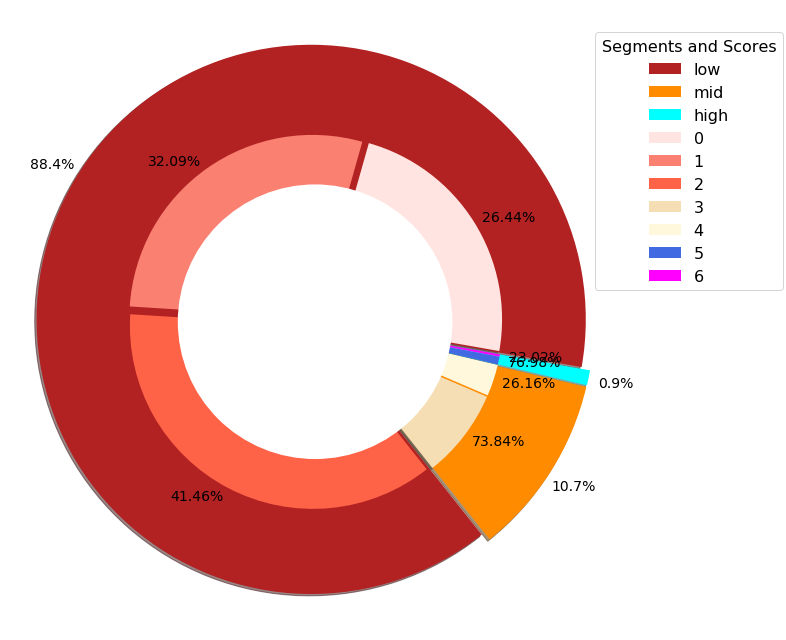

In [303]:
# Data to plot
labels = ['low', 'mid', 'high']
sizes = df_user_full.value_segment.value_counts()
labels_gender = ['0','1','2','3','4','5','6']
sizes_gender = scorelist
colors = ["firebrick", "darkorange", "aqua"]
colors_gender = ["mistyrose", "salmon", "tomato", "wheat", "cornsilk",  "royalblue", "fuchsia"]
explode = (0.05,0.05,0.05) 
explode_gender = (0.05,0.05,0.05,0.05,0.05,0.05,0.05)
#Plot
plt.pie(sizes, colors=colors, startangle=-10, frame=True, explode=explode, radius=3,
        autopct='%1.1f%%', pctdistance=1.1, shadow=True, textprops={'fontsize': 14})
plt.pie(sizes_gender, labels=pctlist, labeldistance=1.05, colors=colors_gender,# autopct='%1.1f%%',
        startangle=-10, explode=explode_gender, radius=2, pctdistance=0.85, shadow=True,
       textprops={'fontsize': 14})
#Draw circle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.set_figheight(9)
fig.set_figwidth(9)
fig.gca().add_artist(centre_circle)
fig.legend(labels=labels+labels_gender, fontsize=16, title="Segments and Scores",
           title_fontsize=16, loc='upper right', bbox_to_anchor=(0.72, 0.45, 0.5, 0.5))
plt.axis('equal')
plt.tight_layout()
plt.show()
#fig.savefig( './Data/SegmentScores.png', bbox_inches='tight') 

## Users for business slides

In [6]:
df_user_full.head()

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim,cluster,recency,frequency,score,value_segment,predicted_purchases_oneyear,clv
0,1,147.01,6,1,0,0,73.505,2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Varel,desktop,Firefox,Windows,Germany,0,216,2,1,low,0.11,2.72
1,3,84.11,0,1,0,0,84.110,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Lower Saxony,Buchholz in der Nordheide,tablet,Safari,iOS,Germany,0,339,1,0,low,0.06,1.64
2,4,62.32,1,4,0,0,62.320,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,desktop,Chrome,Windows,Germany,0,42,1,2,low,0.21,6.10
3,5,89.89,0,0,4,0,44.945,2,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Schleswig-Holstein,Neumunster,tablet,Safari,iOS,Germany,0,185,2,1,low,0.14,3.81
4,6,25.20,1,0,0,0,25.200,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,North Rhine-Westphalia,Meinerzhagen,mobile,Chrome,Android,Germany,0,71,1,2,low,0.17,4.71


In [10]:
#user A
df_user_full[df_user_full["user_id"]==367857]

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim,cluster,recency,frequency,score,value_segment,predicted_purchases_oneyear,clv
251677,367857,87.49,1,0,0,0,87.49,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Austria,Vienna,Vienna,mobile,Safari (in-app),iOS,Austria,0,52,1,2,low,0.19,5.52


In [34]:
#user B
df_user_full[df_user_full["user_id"]==286487]

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim,cluster,recency,frequency,score,value_segment,predicted_purchases_oneyear,clv
598521,286487,713.22,28,2,0,0,79.246667,9,3.222222,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,established,Germany,Lower Saxony,Bovenden,mobile,Android Webview,Android,Germany,2,16,9,4,mid,4.48,121.43


In [20]:
#user C
df_user_full[df_user_full["user_id"]==29842]

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim,cluster,recency,frequency,score,value_segment,predicted_purchases_oneyear,clv
619435,29842,5589.87,85,92,0,0,107.4975,52,3.5,4.0,1.0,4.0,1.0,3.0,1.0,8.0,3.0,10.0,2.0,7.0,1.0,12.0,2.0,established,Germany,Bavaria,Sonthofen,desktop,Safari,Macintosh,Germany,3,8,52,6,high,23.71,808.54
